In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
## This sets the plot style
## to have a grid on a dark background
sns.set_style("darkgrid")
import re
import os
import emoji
import nltk
import string
import itertools
import pandas as pd
import datetime


import itertools
from data_utils import search, clean_data,count_hashtag,get_tweets,hashtag_count_value,week_day

from collections import Counter
import operator

from wordcloud import WordCloud

In [32]:
## Some functions to clean our data
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', text)

def clean_data(text):
    if type(text) != str:
        text = str(text)
    c_data= re.sub(r"(?:\|http?\://|https?\://|www)\S+", "", text) 
    c_data = re.sub('[0-9]+', '', c_data)
    c_data=" ".join(c_data.split())
    c_data  = "".join([char for char in c_data if char not in string.punctuation])
    c_data=''.join(c for c in c_data if c not in emoji.UNICODE_EMOJI)
    c_data=c_data.replace("#", "").replace("_", " ")
    c_data=c_data.replace('“', '')
    c_data=c_data.replace('”','')
    c_data=c_data.replace('…','')
    c_data=deEmojify(c_data)
    c_data = c_data.lower()
    new  = re.sub('[^A-Za-z0-9]+', ' ', c_data)
    return new

In [68]:
df = pd.read_csv("https://raw.githubusercontent.com/edwardcqian/climate_change_sentiment/master/data/sample_data.csv")

In [69]:
## Get rid of sentiments that correspond to news, i.e. a sentiment value of "2"
df = df.loc[df['sentiment']!=2] 
df.reset_index(inplace=True) ## Reset the index values
print("Reduced number of tweets:", len(df))

df['clean_data'] = df['message'].apply(clean_data)
df = df[['sentiment','clean_data','message']] ## We don't need the tweetid
df.head(5)

Reduced number of tweets: 34667


,sentiment,clean_data,message
0,-1,tiniebeany climate change is an interesting hu...,@tiniebeany climate change is an interesting h...
1,1,rt natgeochannel watch beforetheflood right he...,RT @NatGeoChannel: Watch #BeforeTheFlood right...
2,1,fabulous leonardo dicaprios film on climate ch...,Fabulous! Leonardo #DiCaprio's film on #climat...
3,1,rt mickfanning just watched this amazing docum...,RT @Mick_Fanning: Just watched this amazing do...
4,0,unamshow awache kujinga na iko global warming,Unamshow awache kujinga na iko global warming ...


In [70]:
## Look at the distribution of stances in our dataset
df['sentiment'].value_counts(normalize=True)

 1    0.662359
 0    0.222546
-1    0.115095
Name: sentiment, dtype: float64

We see that our dataset is skewed in favor of tweets with a positive stance on climate change.

In [71]:
## Look at basic statistics about our dataset
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sentiment,34667.0,0.547264,0.691354,-1.0,0.0,1.0,1.0,1.0


In [72]:
## Check to see if there are any missing entries
df.isnull().sum()

sentiment     0
clean_data    0
message       0
dtype: int64

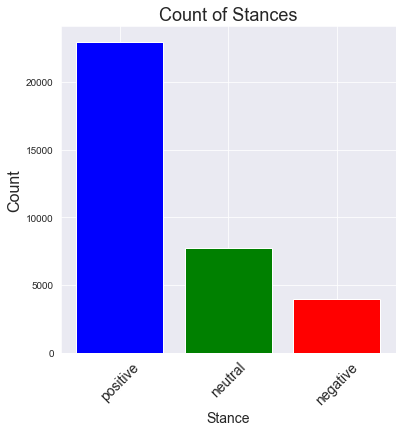

In [73]:
## Plot a distribution of the dataset
plt.figure(figsize=(6,6))
Index = [1,2,3]
Mood_count = df['sentiment'].value_counts()

plt.bar(Index, Mood_count, color=['blue','green', 'red'])
plt.xticks(Index,['positive','neutral','negative'],rotation=45, fontsize=14)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Stance', fontsize=14)
plt.title('Count of Stances', fontsize=18)
plt.annotate(text = Mood_count[0], xy = (0.13,22000), size = 18)

plt.savefig('sentiments_count.png')

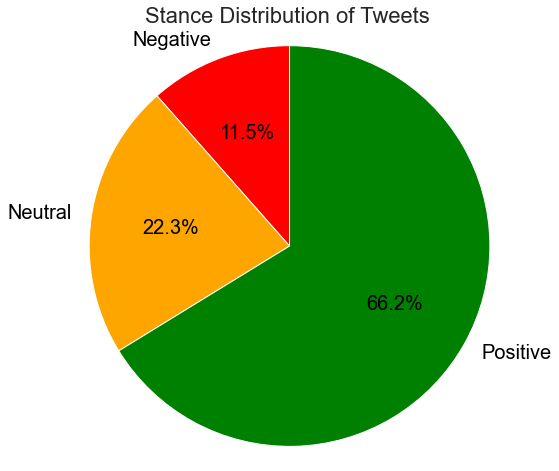

In [74]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Negative', 'Neutral', 'Positive'
mycolors = ["red", "orange", "green"]

moods = df['sentiment'].value_counts(normalize=True)
sizes = [moods[-1], moods[0], moods[1]]

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, labels=labels, colors = mycolors,
        textprops={'fontsize': 20, 'color': 'black'},
        autopct='%1.1f%%', 
        shadow = False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Stance Distribution of Tweets', fontsize=22)

plt.savefig('sentiments_piechart.png')
plt.show()

count    34667.000000
mean        17.206825
std          4.936693
min          0.000000
25%         14.000000
50%         18.000000
75%         21.000000
max         31.000000
dtype: float64


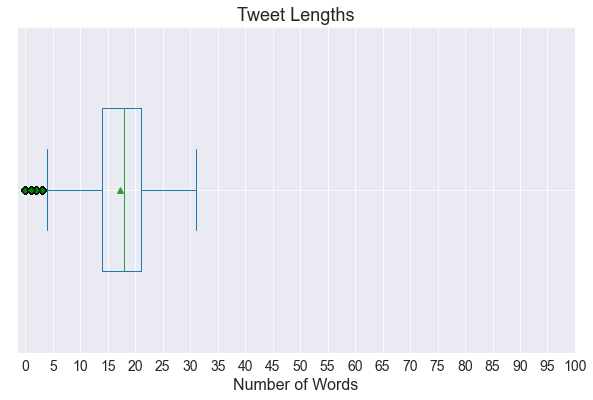

In [40]:
# Calculate tweet lengths
plt.figure(figsize=(10,6))
tweet_len = pd.Series([len(tweet.split()) for tweet in df['clean_data']])
print(tweet_len.describe())

# The distribution of tweet text lengths
green_diamond = dict(markerfacecolor='g', marker='D')
tweet_len.plot(kind='box', vert=False, widths=0.5, 
               showmeans=True,
               flierprops=green_diamond)
plt.xlabel('Number of Words', fontsize=16)
plt.xticks(np.arange(0, 101, 5), fontsize=14)
plt.yticks([1], " ")
plt.title("Tweet Lengths", fontsize=18)
plt.show()

In [41]:
df_new = df.copy()
df_new['length'] = df.clean_data.str.split().apply(len)
df_new.head()

,sentiment,clean_data,message,length
0,-1,tiniebeany climate change is an interesting hu...,@tiniebeany climate change is an interesting h...,23
1,1,rt natgeochannel watch beforetheflood right he...,RT @NatGeoChannel: Watch #BeforeTheFlood right...,16
2,1,fabulous leonardo dicaprios film on climate ch...,Fabulous! Leonardo #DiCaprio's film on #climat...,13
3,1,rt mickfanning just watched this amazing docum...,RT @Mick_Fanning: Just watched this amazing do...,16
4,0,unamshow awache kujinga na iko global warming,Unamshow awache kujinga na iko global warming ...,7


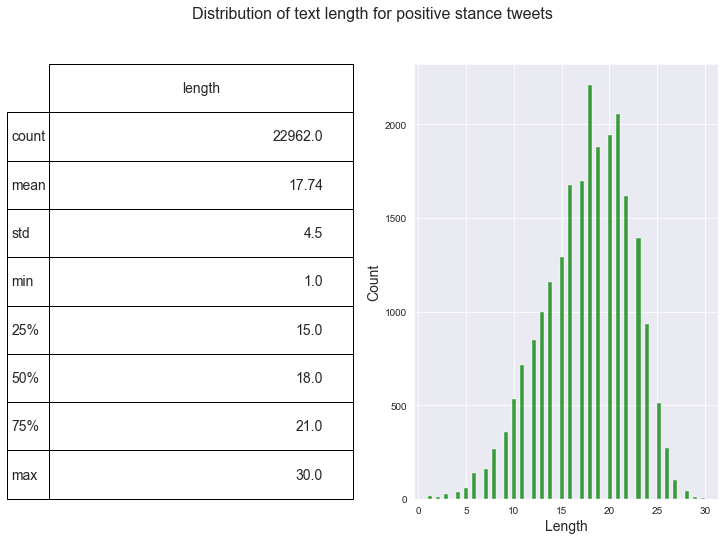

In [42]:
# Plotting the distribution of text length for positive stance tweets
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(122)
hist = sns.histplot(df_new[df_new['sentiment']==1]['length'], ax=ax1,color='green')
hist.set_xlabel("Length", fontsize = 14)
hist.set_ylabel("Count", fontsize = 14)
describe = df_new.length[df_new['sentiment']==1].describe().to_frame().round(2)
ax1.font_size=14

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive stance tweets', fontsize=16)

plt.show()

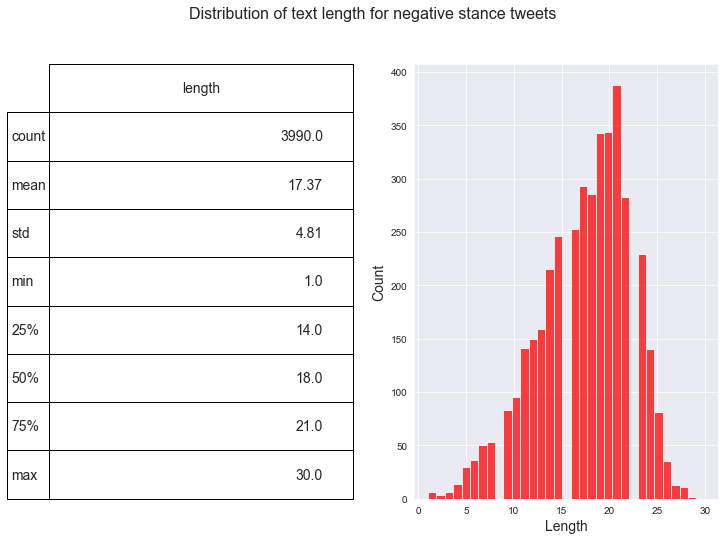

In [43]:
# Plotting the distribution of text length for negative sentiment tweets
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(122)
hist = sns.histplot(df_new[df_new['sentiment']==-1]['length'], ax=ax1,color='red')
hist.set_xlabel("Length", fontsize = 14)
hist.set_ylabel("Count", fontsize = 14)
describe = df_new.length[df_new['sentiment']==-1].describe().to_frame().round(2)
ax1.font_size=14

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for negative stance tweets', fontsize=16)

plt.show()

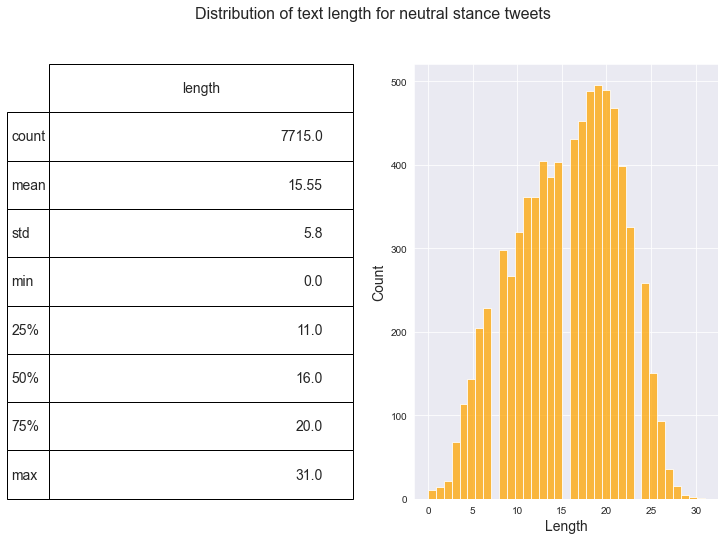

In [44]:
# Plotting the distribution of text length for neutral sentiment tweets
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(122)
hist = sns.histplot(df_new[df_new['sentiment']==0]['length'], ax=ax1,color='orange')
hist.set_xlabel("Length", fontsize = 14)
hist.set_ylabel("Count", fontsize = 14)
describe = df_new.length[df_new['sentiment']==0].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for neutral stance tweets', fontsize=16)

plt.show()

In [28]:
## Count the frequency of words in a dictionary
def count_frequency(dictionary, words):
    for word in words:
        if word not in dictionary.keys():
            dictionary[word] = 1
        else:
            dictionary[word] += 1
    return dictionary

In [45]:
positive_sent = {}
neutral_sent = {}
negative_sent = {}

for i in range(0,len(df)):
    tweet = df['clean_data'].iloc[i]
    tweet = tweet.lower()
    new  = re.sub('[^A-Za-z0-9]+', ' ', tweet) ## Need to get rid of special characters next
    tokens = nltk.word_tokenize(new) ## word_tokenize does not remove duplicates
  
    ## Preserve the order because calling set does not preserve the order of the words
    ordered_tokens = set()
    result = []
    for word in tokens:
        if word not in ordered_tokens:
            ordered_tokens.add(word)
            result.append(word)
            
    if (df['sentiment'].iloc[i] == 1):
        count_frequency(positive_sent, result) 
    elif (df['sentiment'].iloc[i] == 0):
        count_frequency(neutral_sent, result) 
    else:
        count_frequency(negative_sent, result) 

In [46]:
pos = sorted(positive_sent.items(),key=operator.itemgetter(1), reverse=True)
neut = sorted(neutral_sent.items(),key=operator.itemgetter(1), reverse=True)
neg = sorted(negative_sent.items(),key=operator.itemgetter(1), reverse=True)

In [47]:
## Create dataframe from a list of tuples
df_pos = pd.DataFrame(pos, columns = ['word', 'frequency']) 
df_neut = pd.DataFrame(neut, columns = ['word', 'frequency'])
df_neg = pd.DataFrame(neg, columns = ['word', 'frequency'])

print("The number of words in tweets with POSITIVE stance is", len(df_pos))
print("The number of words in tweets with NEUTRAL stance is", len(df_neut))
print("The number of words in tweets with NEGATIVE stance is", len(df_neg))

The number of words in tweets with POSITIVE stance is 30888
The number of words in tweets with NEUTRAL stance is 19473
The number of words in tweets with NEGATIVE stance is 10021


The overlap of all three dataframes.

In [51]:
# A list of dataframes
frame_list = [df_pos, df_neut, df_neg]
inter_all = frame_list[0]
for df in frame_list[1:]:       
    inter_all = pd.merge(inter_all, df, on='word', how='inner')
inter_all = inter_all.rename(columns = {"frequency_x": "positive stance", 
                                        "frequency_y": "neutral stance",
                                       "frequency": "negative stance"})

print("The number of words appearing in tweets with all of positive, neutral, and negative stance is", 
      len(inter_all))
inter_all.head()

The number of words appearing in tweets with all of positive, neutral, and negative stance is 4230


,word,positive stance,neutral stance,negative stance
0,climate,19010,4441,2190
1,change,18773,4376,2102
2,rt,14568,3469,2058
3,the,9768,2574,1787
4,to,9264,1954,1215


Let's look at the overlaps of the words between the various stances.

In [53]:
inter_pos_neutral = pd.merge(df_pos, df_neut, how = 'inner', on = ['word'])
inter_pos_neutral = inter_pos_neutral.rename(columns = {"frequency_x": "positive stance", "frequency_y": "neutral stance"})
print("The size of the overlap b/w words in POSITIVE and NEUTRAL stance tweets is", len(inter_pos_neutral))
inter_pos_neutral.head(10)

The size of the overlap b/w words in POSITIVE and NEUTRAL stance tweets is 8542


,word,positive stance,neutral stance
0,climate,19010,4441
1,change,18773,4376
2,rt,14568,3469
3,the,9768,2574
4,to,9264,1954
5,is,6649,1655
6,of,6240,1424
7,a,5788,1598
8,in,5431,1276
9,and,4977,1278


In [54]:
inter_pos_neg = pd.merge(df_pos, df_neg, how = 'inner', on = ['word'])
inter_pos_neg = inter_pos_neg.rename(columns={"frequency_x": "positive stance", "frequency_y": "negative stance"})
print("The size of the overlap b/w words in POSITIVE and NEGATIVE stance tweets is", len(inter_pos_neg))
inter_pos_neg.head(10)

The size of the overlap b/w words in POSITIVE and NEGATIVE stance tweets is 5575


,word,positive stance,negative stance
0,climate,19010,2190
1,change,18773,2102
2,rt,14568,2058
3,the,9768,1787
4,to,9264,1215
5,is,6649,1325
6,of,6240,930
7,a,5788,923
8,in,5431,686
9,and,4977,657


In [55]:
inter_neg_neut = pd.merge(df_neg, df_neut, how = 'inner', on = ['word'])
inter_neg_neut = inter_neg_neut.rename(columns={"frequency_x": "negative stance", "frequency_y": "neutral stance"})
print("The size of the overlap b/w words in NEGATIVE and NEUTRAL stance tweets is", len(inter_neg_neut))
inter_neg_neut.head(10)

The size of the overlap b/w words in NEGATIVE and NEUTRAL stance tweets is 4795


,word,negative stance,neutral stance
0,climate,2190,4441
1,change,2102,4376
2,rt,2058,3469
3,global,1835,3169
4,warming,1792,3061
5,the,1787,2574
6,is,1325,1655
7,to,1215,1954
8,of,930,1424
9,a,923,1598


Let's figure out the words that correspond only to POSITIVE stance.

In [56]:
## Remove all words from the positive stance dataframe that overlap with the negative stance dataframe 
## and the neutral stance dataframe

df_pos = df_pos.rename(columns={"frequency": "positive stance"})

## Remove duplicates of words with a negative stance
df_inter = inter_pos_neg[['word', 'positive stance']].copy()
print("The number of words overlapping with positive and negative stance is", len(df_inter))
df1 = pd.concat([df_pos, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df1))

df1 = df1.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df1))
print()

## Remove duplicates of words with a neutral stance
df_inter = inter_pos_neutral[['word', 'positive stance']].copy()
print("The number of words overlapping with positive and neutral stance is", len(df_inter))

df2 = pd.concat([df1, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df2))

df2 = df2.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df2))
print()

print("Subtract off the intersection between all three sets.")
df_inter = inter_all[['word', 'positive stance']].copy()
print("The number of words overlapping with positive, neutral, and negative stance is", len(df_inter))

df3 = pd.concat([df2, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df3))

df3 = df3.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df3))

df_pos_unique = df3.copy()
print("\nThe number of words that correspond only to POSITIVE stance are:", len(df_pos_unique))
print("\n The most common words that correspond only to POSITIVE stance are:")
df_pos_unique.head(20)

The number of words overlapping with positive and negative stance is 5575
The length BEFORE dropping duplicates is 36463
The length AFTER dropping duplicates is 25313

The number of words overlapping with positive and neutral stance is 8542
The length BEFORE dropping duplicates is 33855
The length AFTER dropping duplicates is 25231

Subtract off the intersection between all three sets.
The number of words overlapping with positive, neutral, and negative stance is 4230
The length BEFORE dropping duplicates is 29461
The length AFTER dropping duplicates is 21001

The number of words that correspond only to POSITIVE stance are: 21001

 The most common words that correspond only to POSITIVE stance are:


,word,positive stance
87,stephenschlegel,507
192,natgeochannel,220
272,actonclimate,158
406,installing,111
408,stake,110
481,imvotingbecause,93
686,bleached,62
719,anemones,59
773,prochoice,55
803,ddlovato,53


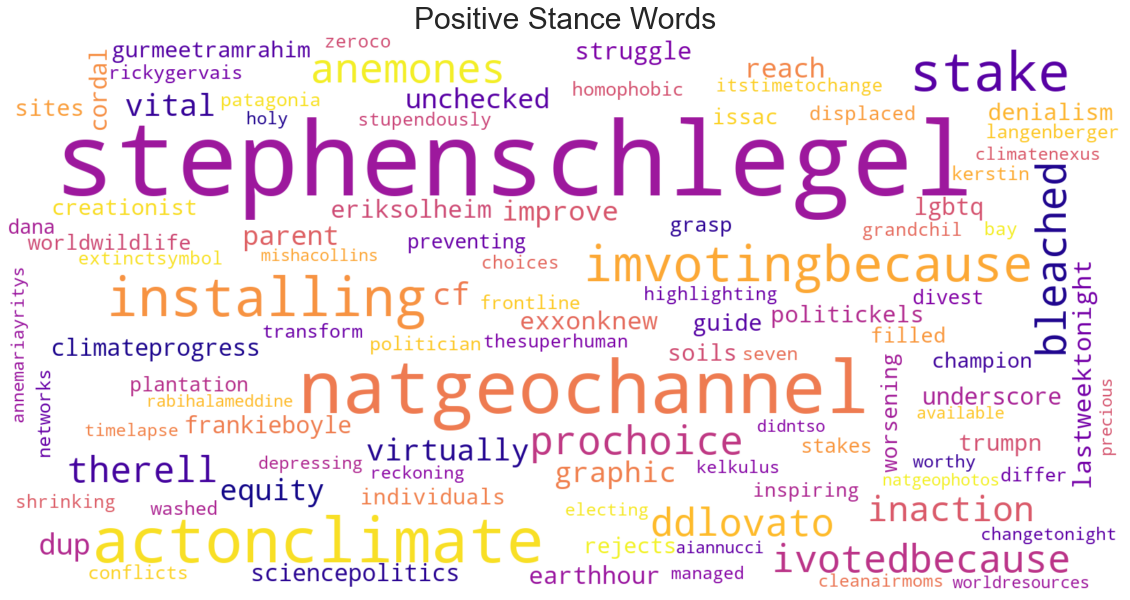

In [61]:
# https://www.datacamp.com/community/tutorials/wordcloud-python 
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

## Make a word cloud of words the correspond to positive stance only
positive_dict = df_pos_unique.set_index('word').T.to_dict('records')

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 100 , width = 1600 , height = 800,
               colormap = "plasma",
               background_color="white").generate_from_frequencies(positive_dict[0])
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title("Positive Stance Words", fontsize =30)
plt.show()

## Save the word cloud to an image
wc.to_file("positive_sent.png")

Let's figure out the words that correspond only to NEGATIVE stance.

In [58]:
## Remove all words from the positive stance dataframe that overlap with the negative stance dataframe
## and neutral stance dataframe

df_neg = df_neg.rename(columns={"frequency": "negative stance"})
print("The number of words with NEGATIVE stance", len(df_neg))

## Remove duplicates of words with a positive stance
df_inter = inter_pos_neg[['word', 'negative stance']].copy()
print("The number of words overlapping with positive and negative stance is", len(df_inter))

df1 = pd.concat([df_neg, df_inter], axis=0)
print("The length BEFORE dropping duplicates is", len(df1))
df1 = df1.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df1))
print()

## Remove duplicates of words with a neutral sentiment
df_inter = inter_neg_neut[['word', 'negative stance']].copy()
print("The number of words overlapping with negative and neutral stance is", len(df_inter))

df2 = pd.concat([df1, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df2))
df2 = df2.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df2))
print()

print("Subtract off the intersection between all three sets.")
df_inter = inter_all[['word', 'negative stance']].copy()
print("The number of words overlapping with positive, neutral, and negative stance is", len(df_inter))

df3 = pd.concat([df2, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df3))

df3 = df3.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df3))

df_neg_unique = df3.copy()
print("\nThe number of words that correspond only to NEGATIVE stance are:", len(df_neg_unique))
print("\nThe most common words that correspond only to NEGATIVE stance are:")
df_neg_unique.head(20)

The number of words with NEGATIVE stance 10021
The number of words overlapping with positive and negative stance is 5575
The length BEFORE dropping duplicates is 15596
The length AFTER dropping duplicates is 4446

The number of words overlapping with negative and neutral stance is 4795
The length BEFORE dropping duplicates is 9241
The length AFTER dropping duplicates is 8111

Subtract off the intersection between all three sets.
The number of words overlapping with positive, neutral, and negative stance is 4230
The length BEFORE dropping duplicates is 12341
The length AFTER dropping duplicates is 3881

The number of words that correspond only to NEGATIVE stance are: 3881

The most common words that correspond only to NEGATIVE stance are:


,word,negative stance
172,alarmists,46
336,hysteria,24
343,pjnet,23
349,countermoonbat,23
375,usfreedomarmy,21
491,elitists,16
567,globalist,14
579,cooked,14
594,leftists,13
609,faked,13


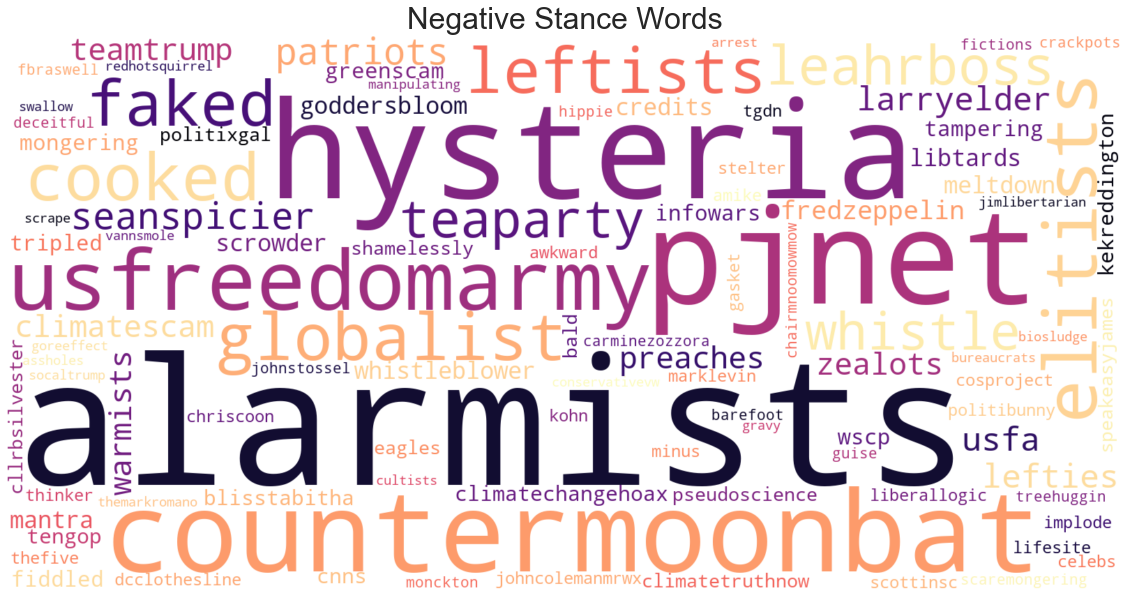

In [64]:
negative_dict = df_neg_unique.set_index('word').T.to_dict('records')

## Make a word cloud of words the correspond to negative stance only
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 100 , width = 1600 , height = 800, 
               background_color="white",
               colormap = "magma").generate_from_frequencies(negative_dict[0])
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title("Negative Stance Words", fontsize =30)
plt.show()

## Save the word cloud to an image
wc.to_file("negative_sent.png")

Let's figure out the words that correspond only to NEUTRAL stance.

In [65]:
# Remove all words from the neutral stance dataframe that overlap with the negative stance dataframe 
# nd positive stance dataframe

df_neut = df_neut.rename(columns={"frequency": "neutral stance"})
print("The number of words with NEUTRAL stance", len(df_neut))

## Remove duplicates of words with a positive stance
df_inter = inter_pos_neutral[['word', 'neutral stance']].copy()
print("The number of words overlapping with positive and neutral stance is", len(df_inter))

df1 = pd.concat([df_neut, df_inter], axis=0)

print("The length BEFORE dropping duplicates is", len(df1))
df1 = df1.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df1))
print()

## Remove duplicates of words with a negative stance
df_inter = inter_neg_neut[['word', 'neutral stance']].copy()
print("The number of words overlapping with negative and neutral stance is", len(df_inter))

df2 = pd.concat([df1, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df2))
df2 = df2.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df2))
print()

print("Subtract off the intersection between all three sets.")
df_inter = inter_all[['word', 'neutral stance']].copy()
print("The number of words overlapping with positive, neutral, and negative stance is", len(df_inter))

df3 = pd.concat([df2, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df3))

df3 = df3.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df3))

df_neutral_unique = df3.copy()
print("\nThe number of words that correspond only to NEUTRAL stance are:", len(df_neutral_unique))
print("\nThe most common words that correspond only to NEUTRAL stance are:")
df_neutral_unique.head(20)

The number of words with NEUTRAL stance 19473
The number of words overlapping with positive and neutral stance is 8542
The length BEFORE dropping duplicates is 28015
The length AFTER dropping duplicates is 10931

The number of words overlapping with negative and neutral stance is 4795
The length BEFORE dropping duplicates is 15726
The length AFTER dropping duplicates is 14596

Subtract off the intersection between all three sets.
The number of words overlapping with positive, neutral, and negative stance is 4230
The length BEFORE dropping duplicates is 18826
The length AFTER dropping duplicates is 10366

The number of words that correspond only to NEUTRAL stance are: 10366

The most common words that correspond only to NEUTRAL stance are:


,word,neutral stance
366,civiljustus,32
515,ultravlolence,23
742,jayzimmer,16
802,del,15
843,jedrlee,14
858,gaga,14
976,ko,12
1015,salvesayson,11
1073,pitbull,11
1137,yung,10


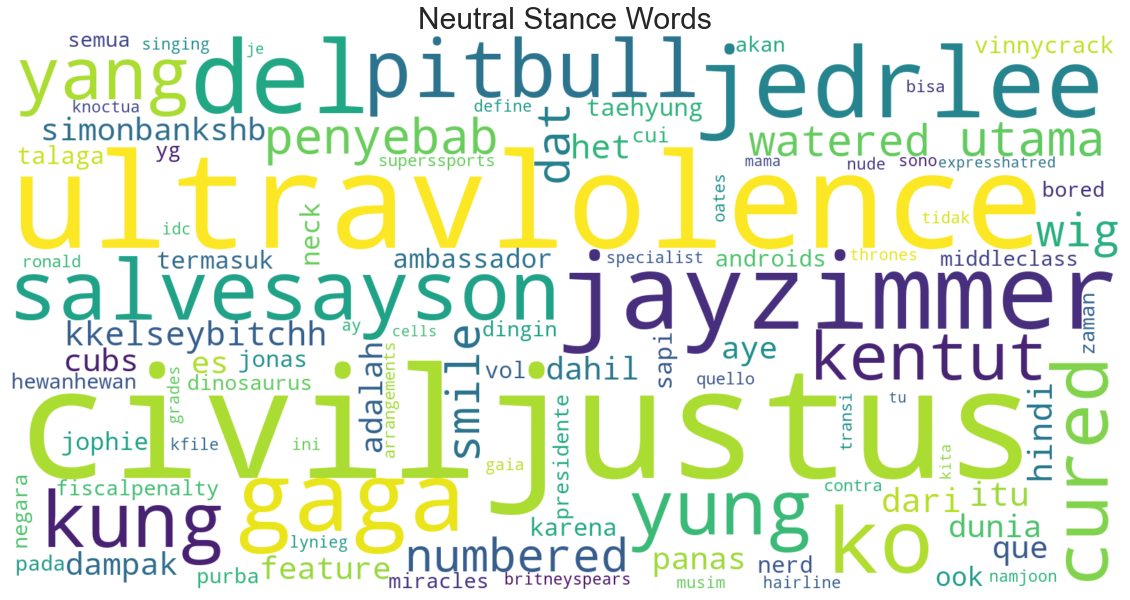

In [66]:
neutral_dict = df_neutral_unique.set_index('word').T.to_dict('records')

## Make a word cloud of words the correspond to neutral stance only
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 100 , width = 1600 , height = 800,
               background_color="white").generate_from_frequencies(neutral_dict[0])
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title("Neutral Stance Words", fontsize =30)
plt.show()

## Save the word cloud to an image
wc.to_file("neutral_sent.png")